In [3]:
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [4]:
import os
import shutil

path = "/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData/"
os.makedirs("/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData/flair", exist_ok=True)
os.makedirs("/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData/t1", exist_ok=True)
os.makedirs("/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData/t1ce", exist_ok=True)
os.makedirs("/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData/t2", exist_ok=True)
os.makedirs("/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData/labels", exist_ok=True)

for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
        if "flair.nii" in filename:
            source_path = os.path.join(dirpath, filename)
            dest_path = os.path.join(path, "flair")
            try:
                shutil.copy(source_path, dest_path)
            except shutil.SameFileError:
                None
        if "t1.nii" in filename:
            source_path = os.path.join(dirpath, filename)
            dest_path = os.path.join(path, "t1")
            try:
                shutil.copy(source_path, dest_path)
            except shutil.SameFileError:
                None
        if "t2.nii" in filename:
            source_path = os.path.join(dirpath, filename)
            dest_path = os.path.join(path, "t2")
            try:
                shutil.copy(source_path, dest_path)
            except shutil.SameFileError:
                None
        if "t1ce.nii" in filename:
            source_path = os.path.join(dirpath, filename)
            dest_path = os.path.join(path, "t1ce")
            try:
                shutil.copy(source_path, dest_path)
            except shutil.SameFileError:
                None
        # if "seg" in filename:
        #     source_path = os.path.join(dirpath, filename)
        #     dest_path = os.path.join(path, "labels")
        #     try:
        #         shutil.copy(source_path, dest_path)
        #     except shutil.SameFileError:
        #         print("same file")

KeyboardInterrupt: 

In [22]:
# STEP 1 - Load and visualize data
dataInputPath = '/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData/'
imagePathInput = os.path.join(dataInputPath, 'flair/')
maskPathInput = os.path.join(dataInputPath, 'labels/')

dataOutputPath = '/mnt/asgard2/data/lingkai/braTS20/slice/'
imageSliceOutput = os.path.join(dataOutputPath, 'flair/')
maskSliceOutput = os.path.join(dataOutputPath, 'label/')

# STEP 2 - Image normalization
braTS_MIN = 0
braTS_MAX = 3000
braTS_RANGE = braTS_MAX - braTS_MIN

# STEP 3 - Slicing and saving
SLICE_X = False
SLICE_Y = False
SLICE_Z = True

SLICE_DECIMATE_IDENTIFIER = 3

In [11]:
# Load image and see max min Hounsfield units
imgPath = os.path.join(imagePathInput, 'BraTS20_Training_270_flair.nii')
img = nib.load(imgPath).get_fdata()
np.min(img), np.max(img), img.shape, type(img)

(0.0, 2116.0, (240, 240, 155), numpy.memmap)

In [12]:
# Load image mask and see max min Hounsfield units
maskPath = os.path.join(maskPathInput, 'BraTS20_Training_270_seg.nii')
mask = nib.load(maskPath).get_fdata()
np.min(mask), np.max(mask), mask.shape, type(mask)

(0.0, 3.0, (240, 240, 155), numpy.memmap)

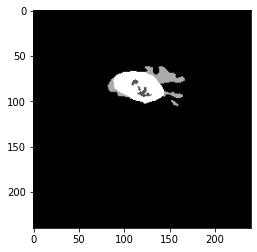

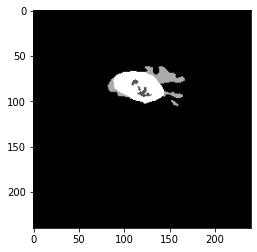

In [13]:
maskSlice = mask[:, :, 60]
plt.imshow(maskSlice, cmap='gray')

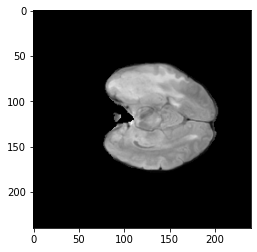

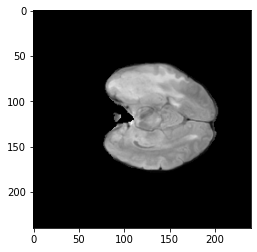

In [14]:
imgSlice = img[:, :, 60]
plt.imshow(imgSlice, cmap='gray')

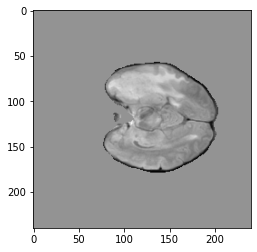

(-3.9187877, 2.8178961, (240, 240), numpy.ndarray)

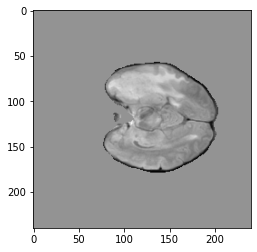

In [15]:
from monai.transforms import NormalizeIntensity, ScaleIntensityRange

normalizeIntensity = NormalizeIntensity(nonzero=True)
imgSliceNorm = normalizeIntensity(imgSlice)
plt.imshow(imgSliceNorm, cmap='gray')
np.min(imgSliceNorm), np.max(imgSliceNorm), imgSliceNorm.shape, type(imgSliceNorm)

In [16]:
from monai.transforms import NormalizeIntensity
# Normalize image

def normalizeImageIntensityRange(imgSlice):
    normalizeIntensity = NormalizeIntensity()
    imgSliceNorm = normalizeIntensity(imgSlice)
    return imgSliceNorm
    

In [18]:
# Read image or mask volume
def readImageVolume(imgPath, normalize=False):
    img = nib.load(imgPath).get_fdata()
    if normalize:
        return NormalizeIntensity(nonzero=True)(img)
    else:
        return img

img = readImageVolume(imgPath, normalize=True)
mask = readImageVolume(maskPath, normalize=False)

In [20]:
# Save volume slice to file
def saveSlice(img, fname, path):
    fout = os.path.join(path, f'{fname}.npy')
    np.save(fout, img)
    print(f'[+] Slice saved: {fout}', end='\r')

# saveSlice(img[:, :, :], 'test', imageSliceOutput)
# saveSlice(mask[120, :, :], 'test', maskSliceOutput)

In [17]:
# Slice image in all directions and save
def sliceAndSaveVolumeImage(vol, fname, path):
    (dimx, dimy, dimz) = vol.shape
    print(dimx, dimy, dimz)
    cnt = 0
    if SLICE_X:
        cnt += dimx
        print('Slicing X:')
        for i in range(dimx):
            saveSlice(vol[i,:,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x', path)
    if SLICE_Y:
        cnt += dimy
        print('Slicing Y: ')
        for i in range(dimy):
            saveSlice(vol[:,i,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y', path)
            
    if SLICE_Z:
        cnt += dimz
        print('Slicing Z: ')
        for i in range(dimz):
            saveSlice(vol[:,:,i], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', path)
    return cnt

In [24]:
# Read and process image volumes
for index, filename in enumerate(sorted(glob.iglob(imagePathInput+'*.nii'))):
    img = readImageVolume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'braTS_Training'+str(index), imageSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData/flair/BraTS20_Training_001_flair.nii (240, 240, 155) 635 -2.4512615 6.9681654
240 240 155
Slicing Z: 
[+] Slice saved: /mnt/asgard2/data/lingkai/braTS20/slice/flair/braTS_Training0-slice154_z.npy
/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData/flair/BraTS20_Training_001_flair.nii, 155 slices created 

/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData/flair/BraTS20_Training_002_flair.nii (240, 240, 155) 635 -2.9916415 8.611498
240 240 155
Slicing Z: 
[+] Slice saved: /mnt/asgard2/data/lingkai/braTS20/slice/flair/braTS_Training1-slice154_z.npy
/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData/flair/BraTS20_Training_002_flair.nii, 155 slices created 

/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData/flair/BraTS20_Training_003_flair.nii (240, 240, 155) 635 -3.7870097 6.0616493
240 240 155
Slicing Z: 
[+] Slice saved: /mnt/asgard2/data/lingkai/braTS20/slice/flair/braTS_Training2-slice154_z.npy
/mnt/asgar

In [23]:
# Read and process mask volumes
for index, filename in enumerate(sorted(glob.iglob(maskPathInput+'*.nii'))):
    img = readImageVolume(filename, False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'braTS_Training'+str(index), maskSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData/labels/BraTS20_Training_001_seg.nii (240, 240, 155) 635 0.0 3.0
240 240 155
Slicing Z: 
[+] Slice saved: /mnt/asgard2/data/lingkai/braTS20/slice/label/braTS_Training0-slice154_z.npy
/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData/labels/BraTS20_Training_001_seg.nii, 155 slices created 

/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData/labels/BraTS20_Training_002_seg.nii (240, 240, 155) 635 0.0 3.0
240 240 155
Slicing Z: 
[+] Slice saved: /mnt/asgard2/data/lingkai/braTS20/slice/label/braTS_Training1-slice154_z.npy
/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData/labels/BraTS20_Training_002_seg.nii, 155 slices created 

/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData/labels/BraTS20_Training_003_seg.nii (240, 240, 155) 635 0.0 3.0
240 240 155
Slicing Z: 
[+] Slice saved: /mnt/asgard2/data/lingkai/braTS20/slice/label/braTS_Training2-slice154_z.npy
/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingD

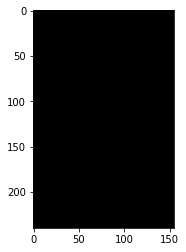

In [97]:
x = np.load('/mnt/asgard2/data/lingkai/braTS20/slice/flair/braTS_Training4-slice001_x.npy')
plt.imshow(x, cmap='gray')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


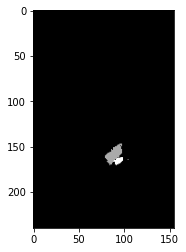

In [92]:
x = np.load('/mnt/asgard2/data/lingkai/braTS20/slice/labels/braTS_Training4-slice150_x.npy')
plt.imshow(x, cmap='gray')

In [33]:
import os

datapath='/mnt/asgard2/data/lingkai/braTS20/slice/'

folderpaths = {
            'mask': os.path.join(datapath, 'labels/'),
            'flair': os.path.join(datapath, 'flair/')
        }

for files in os.listdir(folderpaths['mask']):
    print(files)

braTS_Training350-slice030_x.npy
braTS_Training47-slice215_y.npy
braTS_Training185-slice173_y.npy
braTS_Training40-slice123_x.npy
braTS_Training20-slice172_y.npy
braTS_Training291-slice051_x.npy
braTS_Training363-slice232_y.npy
braTS_Training0-slice027_y.npy
braTS_Training52-slice005_y.npy
braTS_Training108-slice054_y.npy
braTS_Training269-slice188_y.npy
braTS_Training199-slice093_y.npy
braTS_Training133-slice022_y.npy
braTS_Training330-slice116_x.npy
braTS_Training133-slice146_y.npy
braTS_Training120-slice066_x.npy
braTS_Training33-slice126_y.npy
braTS_Training7-slice188_y.npy
braTS_Training58-slice156_y.npy
braTS_Training109-slice140_y.npy
braTS_Training362-slice020_x.npy
braTS_Training326-slice081_y.npy
braTS_Training213-slice219_y.npy
braTS_Training325-slice087_x.npy
braTS_Training107-slice163_y.npy
braTS_Training58-slice179_y.npy
braTS_Training342-slice143_x.npy
braTS_Training360-slice212_x.npy
braTS_Training266-slice163_x.npy
braTS_Training331-slice047_y.npy
braTS_Training59-slic

In [67]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
import os
# Dataset

class TrainDataset(Dataset):
    def __init__(self, datapath='/mnt/asgard2/data/lingkai/braTS20/slice/', augmentation=None):
        self.augmentation = augmentation
        self.folderpaths = {
            'mask': os.path.join(datapath, 'labels/'),
            'flair': os.path.join(datapath, 'flair/')
        }
        self.flair_path = []
        self.label_path = []
        for files in os.listdir(self.folderpaths['mask']):
            flair_path = os.path.join(self.folderpaths['flair'], files)
            label_path = os.path.join(self.folderpaths['mask'], files)
            self.flair_path.append(flair_path)
            self.label_path.append(label_path)

    
    def __getitem__(self, idx):
        images = {}
        
        images['flair'] = np.load(self.flair_path[idx])
        images['mask'] = np.load(self.label_path[idx])
        
        if self.augmentation:
            images = self.augmentaion(image=images['flair'], mask=images['labels'])

            images['flair'] = images['flair']

        for name in images:
            images[name] = torch.from_numpy(images[name])

        # stack modalities 
        # input = torch.stack([images['t1'], images['t1ce'], images['t2'], images['flair']], dim=0)
        input = images['flair']
        # map pixels with value of 4 to 3
        images['mask'][images['mask']==4] = 3
        
        # one-hot encode ground truth
        images['mask'] = F.one_hot(images['mask'].long().unsqueeze(0), num_classes=4).permute(0, 3, 1, 2).contiguous().squeeze(0)

        return input.float(), images['mask'].long()

    def __len__(self):
        return len(os.listdir(self.folderpaths['mask'])) - 1


In [68]:
import albumentations as A

augmentation = A.Compose([
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5)
    ], p=0.8),
    A.RandomBrightnessContrast(p=0.8)
])

# valid_test_dataset = Dataset(datapath='/mnt/asgard2/data/lingkai/braTS20/slice/', augmentation=None)

train_dataset = TrainDataset(datapath='/mnt/asgard2/data/lingkai/braTS20/slice/', augmentation=None)

# take 70%/20%/10% of the dataset for train/valid/test

train_length = int(0.7 * len(train_dataset))
valid_length = int(0.2 * len(train_dataset))
test_length = int(0.1 * len(train_dataset))

train_loader=DataLoader(train_dataset, batch_size=16, num_workers=2, shuffle=True)


In [93]:
a,b = next(iter(train_loader))
a.shape, b.shape

(torch.Size([16, 240, 155]), torch.Size([16, 240, 155]))